# STUDENT PERFORMANCE

### Note: If you want to run this notebook on your local machine, you will need to create a google cloud account, enables the APIs, create a google credentials and set it in your environment.



In [1]:

import sys

sys.path.insert(0, home_dir)


In [2]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = home_dir + "ggcredentials.json"

In [3]:
import findspark

findspark.init()

In [4]:
from pyspark.sql.functions import expr, coalesce, when, col, isnan, count, max
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc = SparkContext("local", "SP_presentation")

spark= SparkSession.builder.getOrCreate()


In [5]:
# Custom modules to clean, prepare data and upload them to GCP
import datapreparation as dp, uploadtoGC
import pandas as pd
import re
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# STEP 1: Download and import datasets, use them to build Spark dataframes<br/>
   Link to download datasets: https://analyse.kmi.open.ac.uk/open_dataset

### There are 3 tables that we are interested in: <br/>
1. studentInfo <br/>
  This file contains demographic information about the students together with their results <br/>

2. studentAssessment <br/>
  This file contains the results of students’ assessments. If the student does not submit the assessment, no result is recorded

3. assessments <br/>
  This file contains information about assessments types, ids, date of assessment and weight of assessments

In [6]:
dataset_path = home_dir + "dataset/"

# File location and type
studentInfo_location = dataset_path + "studentInfo.csv"
studentAssessment_location = dataset_path + "studentAssessment.csv"
assessments_location = dataset_path + "assessments.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# Load student info table
student_info = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(studentInfo_location)


# Load student assessment table
student_assessments = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(studentAssessment_location)


# Load assessment table
assessments = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(assessments_location)


  

## For the purpose of this demo, I only picked out information about code_module BBB and code_representaion 2013B

In [7]:
bbb2013b = student_info.where( (col('code_module') == 'BBB') & (col('code_presentation') == '2013B') )

## Collect all distinct id_assessment that have code_module = 'BBB' and code_presentation = '2013B'

In [8]:
rows_id_assessment = assessments.select('id_assessment').where((col('code_module') == 'BBB') & (col('code_presentation') == '2013B')).collect()

id_assessment_list = [int(rows_id_assessment[i][0]) for i in range(len(rows_id_assessment))]


## Build each df for each id_assessment that store students' scores

In [9]:
dfs = []

for i in range(len(id_assessment_list)):
  dfs.append( student_assessments.select([student_assessments.id_assessment.alias('id_a'),\
                                          student_assessments.id_student.alias('id_s') ,\
                                          student_assessments.score.alias('score_' + str(id_assessment_list[i]))])\
                                          .where( student_assessments.id_assessment == id_assessment_list[i] ) )

## Join all grades with the "big" DataFrame bbb2013b that stores all students' info

In [10]:
for i in range (len(dfs)):
  cols = bbb2013b.columns
  bbb2013b = bbb2013b.join(dfs[i], bbb2013b.id_student == dfs[i].id_s,  how = 'left' ).select(*cols, dfs[i].columns[-1])

In [11]:
bbb2013b.show(5)

+-----------+-----------------+----------+------+-------------------+--------------------+--------+--------+--------------------+---------------+----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|code_module|code_presentation|id_student|gender|             region|   highest_education|imd_band|age_band|num_of_prev_attempts|studied_credits|disability|final_result|score_14991|score_14992|score_14993|score_14994|score_14995|score_14984|score_14985|score_14986|score_14987|score_14988|score_14989|score_14990|
+-----------+-----------------+----------+------+-------------------+--------------------+--------+--------+--------------------+---------------+----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|        BBB|            2013B|     23629|     F|East Angl

## Save the original dataframe before moving further

In [12]:
original_df_path = dp.save_csv(bbb2013b, dataset_path, '/original_df')

## Split the dataset into train and test set based on final_result :
### The train dataset is to build a model. 
### The test set is to be used to evaluate how well the model does with data it has not seen before
  

In [13]:
train0, test0 = dp.split_data (bbb2013b, col = 'final_result', ratio = .8)

In [14]:
train0.groupBy('final_result').count().show()

+------------+-----+
|final_result|count|
+------------+-----+
|        Fail|  374|
| Distinction|  122|
|   Withdrawn|  417|
|        Pass|  525|
+------------+-----+



In [15]:
test0.groupBy('final_result').count().show()

+------------+-----+
|final_result|count|
+------------+-----+
|        Fail|   85|
| Distinction|   33|
|   Withdrawn|   88|
|        Pass|  123|
+------------+-----+



### "Zeroth" try - Put every up to Google Cloud without cleaning the dataset
  First try to save train and test set as csvs

In [16]:
train0_dir = dp.save_csv(train0, dataset_path, 'zeroth_try/train')
test0_dir = dp.save_csv(test0, dataset_path, 'zeroth_try/test')

### Import to Google Cloud using a script. This can also easily be done by physically going to GCP website.
#### The result didn't look so good. 


try_th = 'zero'
ds_name = 'hihreyouaaaaaa'
project_id = "myprojectcas02"

uploadtoGC.upload_data(train0_dir, ds_name, try_th, 'train', project_id ,'us-central1', 'local')

#### I've tried 3 times using Google Cloud AutoML and the results did not look promising until after the data goes through our custom-built pipeline to clean it

### OUR ATTEMPT TO BUILD A CUSTOM PIPELINE TO CLEAN DATA<br/>
####  1/ Check if columns have appropriate types. As we'll see there're columns that don't, for ex., scores are supposed to be numeric. So we'll need to convert to the proper datatypes

In [17]:
train0.dtypes

[('code_module', 'string'),
 ('code_presentation', 'string'),
 ('id_student', 'string'),
 ('gender', 'string'),
 ('region', 'string'),
 ('highest_education', 'string'),
 ('imd_band', 'string'),
 ('age_band', 'string'),
 ('num_of_prev_attempts', 'string'),
 ('studied_credits', 'string'),
 ('disability', 'string'),
 ('final_result', 'string'),
 ('score_14991', 'string'),
 ('score_14992', 'string'),
 ('score_14993', 'string'),
 ('score_14994', 'string'),
 ('score_14995', 'string'),
 ('score_14984', 'string'),
 ('score_14985', 'string'),
 ('score_14986', 'string'),
 ('score_14987', 'string'),
 ('score_14988', 'string'),
 ('score_14989', 'string'),
 ('score_14990', 'string')]

#### 2/ We need to inspect if we have columns that contain null. If yes, we have to clean, impute,... before we do some analysis and train Machine Learning models<br/>


In [18]:
train0.select([count(when(isnan(c) | train0[c].isNull(), c)).alias(c) for c in train0.columns]).show()


+-----------+-----------------+----------+------+------+-----------------+--------+--------+--------------------+---------------+----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|code_module|code_presentation|id_student|gender|region|highest_education|imd_band|age_band|num_of_prev_attempts|studied_credits|disability|final_result|score_14991|score_14992|score_14993|score_14994|score_14995|score_14984|score_14985|score_14986|score_14987|score_14988|score_14989|score_14990|
+-----------+-----------------+----------+------+------+-----------------+--------+--------+--------------------+---------------+----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|          0|                0|         0|     0|     0|                0|      18|       0|              

#### First intuitive thought is imd_band (Index of Multiple Deprivation - official measure of relative deprivation for small areas in England) is mostly based on region<br/>
#### The code below shown how I was filling in nulls for imd_band columns based on the region, for ex: region 'South East Region' has imd '60-70%', region 'West Midlands Region' has imd '0-10%', etc

In [19]:
region_imdband_groupby = train0.groupBy(['region', 'imd_band']).count().select(col('region').alias('m_region'), col('imd_band').alias('m_imd_band'), col('count').alias('total_counts'))
maxcount_imdband_by_region = region_imdband_groupby.groupBy(['m_region']).agg(max('total_counts').alias('maxcount')).select(col('m_region').alias('region'), 'maxcount')
conditions = [region_imdband_groupby['total_counts'] == maxcount_imdband_by_region['maxcount'], region_imdband_groupby['m_region'] == maxcount_imdband_by_region['region']]
maxcount_imdband_by_region_records = region_imdband_groupby.join(maxcount_imdband_by_region, conditions, 'inner')
imd_band_replace_dict = maxcount_imdband_by_region_records.select('region', 'm_imd_band').dropDuplicates(['region']).collect()

list_imdband = [list(row) for row in imd_band_replace_dict]
mdict_imd = {l[0]: l[1] for l in list_imdband}



In [20]:
for key, val in mdict_imd.items():
    print (key, ": ", val)

East Anglian Region :  70-80%
South West Region :  20-30%
Wales :  0-10%
West Midlands Region :  0-10%
South East Region :  60-70%
North Western Region :  0-10%
East Midlands Region :  20-30%
Ireland :  10-20
Yorkshire Region :  0-10%
North Region :  10-20
London Region :  20-30%
South Region :  90-100%
Scotland :  20-30%


#### Build up conditional statement used to fill imd_band column based on region

In [21]:
imd_cond_str = dp.cond_statement('region', mdict_imd)

### Ranking education levels also help to make the result of model better

In [22]:
edu_dict = {'Lower Than A Level': 0, 'No Formal quals': 0 , 'A Level or Equivalent': 1, 'HE Qualification': 2, 'Post Graduate Qualification': 3}

edu_cond_str = dp.cond_statement('highest_education', edu_dict)

### Also from training results I got with AutoML, the models seemed to be confused alot by final_resul. To simplify the training process and get better result, I'll convert "Distinction" and "Pass" to "Pass", "Fail" otherwise

In [23]:
final_result_dict = {'Pass': 'Pass', 'Distinction': 'Pass', 'Fail': 'Fail', 'Withdrawn': 'Fail'}
final_result_cond_str = dp.cond_statement('final_result', final_result_dict)


#### Specify steps to clean our dataset. Drop columns, fill nas, cast some columns' datatypes and impute/fix columns imd_band and rank education column,...<br/>
#### This is our custom "Cleaning Pipeline"

In [24]:
cols_to_drop = ['code_module', 'code_representation', 'id_student', 'score_14990', 'code_presentation']
numeric_cols = ['score_14991', 'score_14992', 'score_14993', 'score_14994', 'score_14995', 'score_14984', 'score_14985', 'score_14986', 'score_14987', 'score_14988', 'score_14989']
numeric_cols.append('num_of_prev_attempts')


clean_steps = {'drop_cols': cols_to_drop,
               'cast_cols_dtype': [numeric_cols, 'double'],
               'fill_na': [numeric_cols, 0],               
               'impute_cols': [['imd_band', imd_cond_str]],
               'rank_cols': [['highest_education', edu_cond_str]],
               'convert_cols': [['final_result', final_result_cond_str]]}

#to_dos = ['drop_cols', 'cast_cols_dtype', 'fill_na', 'impute_cols']

train1 = dp.cleaning_stages (train0, **clean_steps)

#### Check again to see if we still have nulls.

In [25]:
train1.select([count(when(isnan(c) | train1[c].isNull(), c)).alias(c) for c in train1.columns]).show()

+------+------+-----------------+--------+---------------+----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+--------+------------------------+----------------------+
|gender|region|highest_education|age_band|studied_credits|disability|final_result|score_14991|score_14992|score_14993|score_14994|score_14995|score_14984|score_14985|score_14986|score_14987|score_14988|score_14989|num_of_prev_attempts|imd_band|ranked_highest_education|converted_final_result|
+------+------+-----------------+--------+---------------+----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+--------+------------------------+----------------------+
|     0|     0|                0|       0|              0|         0|           0|          0|          0|          0|   

### Save train1 df

In [26]:
train1_dir = dp.save_csv(train1, dataset_path, 'first_try/train')

In [27]:
train1.groupby('converted_final_result').count().show()

+----------------------+-----+
|converted_final_result|count|
+----------------------+-----+
|                  Fail|  791|
|                  Pass|  647|
+----------------------+-----+



# TO DO: IMPORT SOME PLOT AND BRIEF ANALYSIS HERE LATER

### Compare the last try I had with Google AutoML and the Logistics Regression model I'd train below, the results were pretty much similar. <br/>



In [28]:

stages = [] # contain stages that data will be transformed


#### Specify types of data: categorical, ordinal, numeric,...

In [29]:
ordinal_categorical_cols = ['ranked_highest_education']
categorical_cols = ['gender', 'region', 'age_band', 'disability', 'imd_band']
numeric_cols = ['score_14991', 'score_14992', 'score_14993', 'score_14994', 'score_14995', 'score_14984', 'score_14985', 'score_14986', 'score_14987', 'score_14988', 'score_14989']
numeric_cols.append('num_of_prev_attempts')

### Build a stages for Pipeline (include the ordered stages that will transform your data)<br/>
 
#### 1/ Binary encoding categorical data. We do this because categorical data should not be ranked, in another word, for column gender, female individuals shouldn't be ranked less than male individuals and vice versa

In [30]:
for col in categorical_cols:
  string_indexer = StringIndexer(inputCol= col, outputCol = col + "Index")
  onehot_encoder = OneHotEncoderEstimator(inputCols = [string_indexer.getOutputCol()], outputCols = [col + "classVec"])
  # Add above transformers into the stages
  stages += [string_indexer, onehot_encoder]


#### 2/ Convert result into a string indices also, named "label". A machine learning model will look for this column as their output data and will based this column with the result from their predictions to calculate some results statistics.

In [31]:
label_stringIdx = StringIndexer(inputCol = 'converted_final_result', outputCol = 'label', stringOrderType= 'alphabetAsc')

stages += [label_stringIdx]

#### 3/ Standardize numeric columns

In [32]:
numeric_assembler = VectorAssembler(inputCols= numeric_cols, outputCol = 'numeric_f')
standard_scaler = StandardScaler().setInputCol('numeric_f').setOutputCol('standardized_numeric_f')

stages += [numeric_assembler, standard_scaler]

#### 4/ Assemble all the input into a column called "Features". A machine learning model will look for this column as their input data

In [33]:
assembler_inputs = [c + "classVec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols = assembler_inputs, outputCol = 'features')

stages += [assembler]


#### 5/ Feature transformation thru pipeline with stages defined earlier

In [34]:
partial_pipeline = Pipeline().setStages(stages)
pipeline_model = partial_pipeline.fit(train1)
prepped_train1 = pipeline_model.transform(train1) 

#### 6/ STARTING TRAINING MODEL<br/>
LOGISTIC REGRESSION
https://spark.apache.org/docs/latest/mllib-linear-methods.html#logistic-regression

In [35]:
lr= LogisticRegression(labelCol= 'label', featuresCol= 'features', tol=1e-6)



#### 6.1/ Tuning the parameter
#### Define a parameter grid: We choose to have a total of 2*2 = 4 combinations of parameters to go choose from

In [36]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam,  [0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.5, 1.0])
             .build())

#### 6.2/ Better way to evaluate the performance of a model: Cross-validation
#### 3 fold-cross validations together with 4 combinations of parameters above, so the model will run 12 times, then store the best model it's seen.


In [37]:
evaluator = BinaryClassificationEvaluator()

cv = CrossValidator(estimator = lr, estimatorParamMaps= paramGrid, evaluator= evaluator, numFolds= 3)

cv_model = cv.fit(prepped_train1)

#### Evaluate our model: metrics= area under ROC (Receiver Operationg Charasteristics or FPR vs TPR) Curve. Optimal area = 1


In [38]:
predictions_train = cv_model.transform(prepped_train1)

roc_area = evaluator.evaluate(predictions_train)

print ("Area under ROC Curve = ", roc_area)

Area under ROC Curve =  0.9714924664453464


#### Convert final_result  :  'Pass'  to 0 and 'Fail to 0

In [39]:
from pyspark.sql.functions import col, when
predictions_train = predictions_train.withColumn("converted_final_result_int", when(col('converted_final_result') == 'Pass', 1).otherwise(0))

### Convert the results to pandas dataframe for better options for visualization

In [40]:
results_pd = predictions_train[['converted_final_result', 'converted_final_result_int', 'prediction', 'rawPrediction', 'probability' ]].toPandas()

### Take a look at our confusion matrix
#### True Negative = 728, False Positive = 63, False Negative = 69, True Positive = 578

#### True Positive Rate: 578 / (578+69) = 0.8934
#### True Negative Rate: 728 / (728+63) = 0.9204
#### False Positive Rate: 63 / (728+63) = 0.0796
#### False Negative Rate: 69 / (578+69) = 0.1066
#### Accuracy = sqrt(True Positive Rate * True Negative Rate ) = .9068


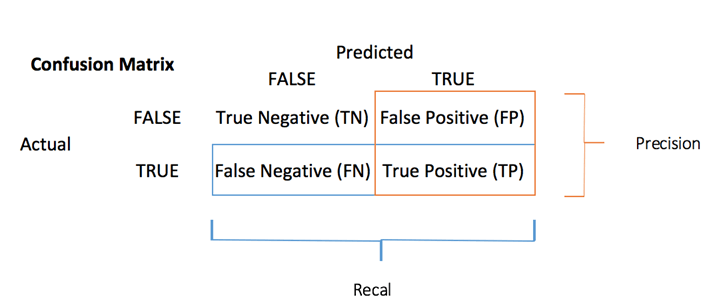

In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(results_pd['converted_final_result_int'], results_pd['prediction'])

array([[728,  63],
       [ 69, 578]])

In [42]:
pos_probs = []

for i in range(len(results_pd)):
    pos_prob = results_pd['probability'][i][1]
    pos_probs.append(pos_prob)
    
pos_probs = np.array(pos_probs)

In [43]:
fpr, tpr, thresholds = roc_curve(np.array(results_pd['converted_final_result_int']), pos_probs)

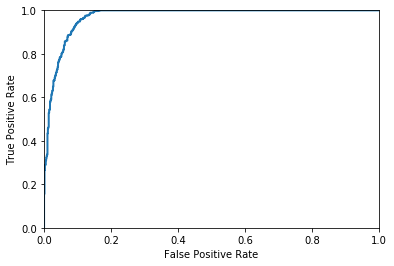

Area under ROC Curve =  0.9714924664453464


In [44]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth= 2)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()
print ("Area under ROC Curve = ", roc_area)

### In our case, we can adjust the probability threshold to achieve a lower Fall Positive Rate (we want to be able to predict as many actual "failing" students as possible)

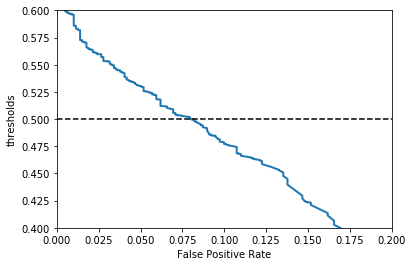

In [45]:
def plot_fpr_thresholds(fpr, thresholds):
    plt.plot(fpr, thresholds, linewidth= 2)
    plt.plot([0, 0.2], [0.5, 0.5], 'k--')
    plt.axis([0,0.2,0.4,0.6])
    plt.xlabel('False Positive Rate')
    plt.ylabel('thresholds')
    
plot_fpr_thresholds(fpr, thresholds)
plt.show()


### We can always train more models, but let assume we are happy with what we have and are ready to have it tested on our test set

In [46]:
test1_cleaned = dp.cleaning_stages (test0, **clean_steps)

In [48]:
#Predictions on test set
test1_prepped = pipeline_model.transform(test1_cleaned)



In [49]:
predictions_test = cv_model.transform(test1_prepped)

### On our test set, the model did a similarly good job. Area under ROC is .973

In [53]:
roc_area_test = evaluator.evaluate(predictions_test)

In [54]:
print (roc_area_test)

0.9730250481695568


### Save a model to use later

In [59]:
cv_model.save(home_dir +"cv_model")

In [68]:
#from pyspark.ml.tuning import CrossValidatorModel
#cv_model_loaded = CrossValidatorModel.load(home_dir +"cv_model")